In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
from pprint import pprint as pp
import scipy.stats
import seaborn as sns
import copy


In [4]:
datapath = "~/teigen_data/output_rows.csv"

In [5]:
def list_filter(lst, startswith=None, notstartswith=None, contain=None, notcontain=None):
    keeped = []
    for item in lst:
        keep = False
        if startswith is not None:
            if item.startswith(startswith):
                keep = True
        if notstartswith is not None:
            if not item.startswith(notstartswith):
                keep = True
        if contain is not None:
            if contain in item:
                keep = True
        if notcontain is not None:
            if not notcontain in item:
                keep = True
                
        if keep:
            keeped.append(item)
    return keeped
            

lst = ["aa" , "sss", "aaron", "rew"]
output = list_filter(lst, notstartswith="aa")
assert(["sss", "rew"] == output)

output = list_filter(lst, contain="ro")
# list_filter(lst, notstartswith="a")
output

['aaron']

In [6]:
plotkw ={
    "figsize": [9, 6], 
    "fontsize": 14, 
}
plot_title_size = 40
plot_linewidth = 3
plot_title_size = None
plot_linewidth = None

plot_boxprops = {
    "linewidth": plot_linewidth
}
boxplotkw = {
    "figsize": [9, 6], 
    "fontsize": 14, 
    "boxprops": plot_boxprops,
    "medianprops": plot_boxprops,
    "whiskerprops": plot_boxprops,
    "capprops": plot_boxprops,
    
}

figurekw = {
    "figsize": [9, 6]
}

plotkw = {}
boxplotkw = {}
figurekw = {}


In [7]:

run_label_key = "run_label"

In [8]:
available_radius_methods = [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder volume + sphere error",
    "cylinder volume + sphere error + man",
    "cylinder volume + sphere error + join error",
    "cylinder surface", 
    "cylinder surface + sphere error",
    "cylinder surface + sphere error + join error",
    "cylinder surface + sphere error + join error man",
    "best",
    
]

In [9]:
def dfplot(dfs, plotkw, radius_method=""):
    
    dfsp = dfs[["surface error [%]", "volume error [%]", "measurement_resolution"]].sort_values(
        "measurement_resolution")
    
    return show_error(dfsp, radius_method=radius_method)
    

In [10]:
def append_dataframe_to_csv(df, filename):
    import pandas as pd 
    filename = op.expanduser(filename)
    if op.exists(filename):
        dfin = pd.read_csv(filename)
        df = pd.concat([dfin, df])
    df.to_csv(filename, index=False)

def remove_rows_from_csv(filename, n=1):
    filename = op.expanduser(filename)
    if op.exists(filename):
        dfin = pd.read_csv(filename)
        df = dfin[:-n]
        df.to_csv(filename, index=False)

def run_configs(configs, loglevel=None):
    teigen_ok_fail_list = "~/teigen_ok_fail_list.csv"
    
    if loglevel is None:
        import logging
        debuglevel = logging.WARNING
    
    tg = teigen.tgmain.Teigen()
    tg.set_loglevel(loglevel)
    for i, config in enumerate(configs):
        # old failing
        # tg = teigen.tgmain.Teigen()
        # config = tg.get_default_config()
        tg.use_default_config()
        tg.update_config(**config)
        gc = config["generators"]["Unconnected tubes"]
        print (str(i) + " / " + str(len(configs)))  
        print (config["output"]["note"])
        print("rng {}, r {}, l {}, res {}".format(
            gc["random_generator_seed"], 
            gc["radius_distribution_mean"],
            gc["length_distribution_mean"],
            config["postprocessing"]["measurement_resolution"]
        ))
        rowcfg = tg.config_to_row_dataframe()
        append_dataframe_to_csv(rowcfg, teigen_ok_fail_list)
        tg.step1()
        print("step1 finished")
        tg.step2()
        remove_rows_from_csv(teigen_ok_fail_list)
        print("step2 finished")
        # del(tg)

def select_configs(all_configs, run_list):
    configs = []
    for config in all_configs:
        if config["output"][run_label_key] in run_list:
            configs.append(config)
    return configs

In [11]:
def list_filter(lst, startswith=None, notstartswith=None, contain=None, notcontain=None):
    keeped = []
    for item in lst:
        keep = False
        if startswith is not None:
            if item.startswith(startswith):
                keep = True
        if notstartswith is not None:
            if not item.startswith(notstartswith):
                keep = True
        if contain is not None:
            if contain in item:
                keep = True
        if notcontain is not None:
            if not notcontain in item:
                keep = True
                
        if keep:
            keeped.append(item)
    return keeped
            

lst = ["aa" , "sss", "aaron", "rew"]
output = list_filter(lst, notstartswith="aa")
assert(["sss", "rew"] == output)

output = list_filter(lst, contain="ro")
# list_filter(lst, notstartswith="a")
output

['aaron']

In [12]:
"au" in "plau"

True

In [13]:
"sadfa".startswith("sa")

True

In [14]:
                

def read_data(datapath):
    df = pd.read_csv(op.expanduser(datapath))
    # remove duplicates
    ks = copy.copy(list(df.keys()))
#     ks.remove("processing_info datetime")
    ks = list_filter(ks, notstartswith="processing_info")
    df = df.drop_duplicates(ks)
    df["volume [mm^3]"] = df["measurement volume [mm^3]"]
    df["numeric volume [mm^3]"] = df["measurement numeric volume [mm^3]"]
    df["surface [mm^2]"] = df["measurement surface [mm^2]"]
    df["numeric surface [mm^2]"] = df["measurement numeric surface [mm^2]"]
    
    df["surface error [mm^2]"] = df["numeric surface [mm^2]"] - df["surface [mm^2]"]
    df["surface error [%]"] = df["surface error [mm^2]"] / df["surface [mm^2]"] * 100
    df["volume error [mm^3]"] = df["numeric volume [mm^3]"] - df["volume [mm^3]"]
    df["volume error [%]"] = df["volume error [mm^3]"] / df["volume [mm^3]"] * 100
    df["measurement_resolution"] = df["config postprocessing measurement_resolution"]
    df["length_distribution_mean"] = df["config generators Unconnected tubes length_distribution_mean"]
    df["radius_distribution_mean"] = df["config generators Unconnected tubes radius_distribution_mean"]
    df["element_number"] = df["config generators Unconnected tubes element_number"]
    df["element number"] = df["element_number"]
    return df
# read_data(datapath)

In [15]:
df = read_data(datapath)

In [16]:
def statistic_tests(dfs, wxparams={}):

    # wilcoxon - čím větší, tím lepší
    vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], **wxparams)
    # spearman čím menší, tím lepší
    vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
    # print dfs.keys()
    # wilcoxon - čím větší, tím lepší, alespoň 0.05
    surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], **wxparams)
    # spearman čím menší, tím lepší
    surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
    return vol_w, vol_s, surf_w, surf_s

def show_error(dfs, x_key="measurement_resolution", radius_method="", plotkw={}, boxplotkw={}, figurekw={}):
    
    sns.set_style("whitegrid")
#     sns.set_context("talk")
    sns.set_context("paper")
    # print "show_error"
    # print dfs.keys()
    dfsp = dfs[["surface error [%]", "volume error [%]", 
                x_key]].sort_values(x_key)

    if len(dfsp) < 1:
        return dfsp
    wxparams = {
        # "correction": True,
        "correction": False,
        "zero_method": "pratt"
        #"zero_method": "wilcox"
    }
    vol_w, vol_s, surf_w, surf_s = statistic_tests(dfs, wxparams)
#     # wilcoxon - čím větší, tím lepší
#     vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], **wxparams)
#     # spearman čím menší, tím lepší
#     vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
#     # print dfs.keys()
#     # wilcoxon - čím větší, tím lepší, alespoň 0.05
#     surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], **wxparams)
#     # spearman čím menší, tím lepší
#     surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
#     print radius_method, len(dfsp), ":\nvolume (w/s): \n", vol_w, "\n",vol_s, "\n", "surface (w/s): \n" , surf_w,"\n", surf_s, "\n"

    fig = plt.figure(**figurekw)
    ax = plt.subplot(141)
    dfsp[["volume error [%]", x_key]].plot(
        ax=ax, x=x_key, 
#         linewidth=plot_linewidth,
        **plotkw)
    ax = plt.subplot(142)
    dfsp[["surface error [%]", x_key]].plot(
        ax=ax, x=x_key, 
#         linewidth=plot_linewidth, 
        **plotkw)
    ax = plt.subplot(143)
    
#     sns.set_style("whitegrid")
#     sns.set_context("talk")
#     sns.boxplot(
#         y="surface error [%]",
#     #     x="config output note", 
#     #     x="surface",
#     #     data=df, 
#         data=df, 
#         palette="muted"
#     )
    dfsp[["volume error [%]"]].plot(
        ax=ax, kind="box", **boxplotkw)
    ax = plt.subplot(144)
    dfsp[["surface error [%]"]].plot(
        ax=ax, kind="box", **boxplotkw)
    plt.tight_layout()
    plt.suptitle("{} \nvolume wx {} sp {} \nsurface wx {} sp {}".format(
        radius_method, 
        vol_w.pvalue, 
        vol_s.pvalue,
        surf_w.pvalue, 
        surf_s.pvalue
    )
#                  size=plot_title_size
                )
    return dfsp
# show_error(df)


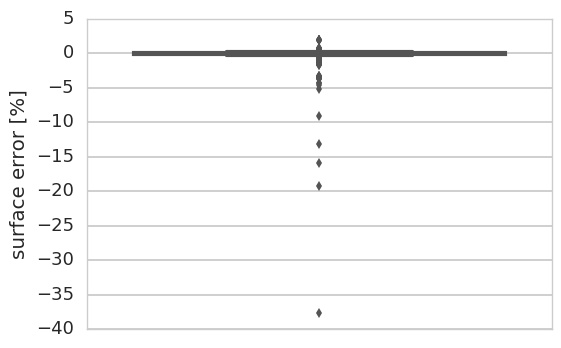

In [17]:

dfs =  df[["surface error [%]", "volume error [%]", "config output note"]].rename(
    columns={
        "surface error [%]": "surface",
        "volume error [%]": "volume"
    })
df_long = pd.melt(
    dfs,
    "config output note",
    var_name="measurement", 
    value_name="error [%]"
    
)

sns.set_style("whitegrid")
sns.set_context("talk")
sns.boxplot(
    y="surface error [%]",
#     x="config output note", 
#     x="surface",
#     data=df, 
    data=df, 
    palette="muted"
)
# df_long = df_long.rename(columns={"surface error [%]": "surface"})



# # sns.violinplot(
# sns.boxplot(
#     y="error [%]",
# #     x="config output note", 
#     x="measurement",
# #     data=df, 
# #     hue="config output note",
#     data=df_long, 
# )



In [18]:
dfs.rename(columns={"surface error [%]":"s"})

,surface,volume,config output note
0,-0.173384,-0.562160,generated volume resolution_mm inscribed
1,-0.173384,-0.562160,generated volume resolution_mm inscribed
2,-0.173384,-0.562160,generated volume resolution_mm inscribed
3,-0.173384,-0.562160,generated volume resolution_mm inscribed
4,-0.173384,-0.562160,generated volume resolution_mm inscribed
5,-0.173384,-0.562160,generated volume resolution_mm inscribed
6,-0.173384,-0.562160,generated volume resolution_mm inscribed
7,-0.173384,-0.562160,generated volume resolution_mm inscribed
8,-0.173384,-0.562160,generated volume resolution_mm inscribed
9,-0.173384,-0.562160,generated volume resolution_mm inscribed


In [19]:

pd.to_datetime("today")

Timestamp('2017-10-05 00:00:00')

In [20]:
note_key = list_filter(df.keys(), contain="note")[0]
step2_datetime_key = list_filter(df.keys(), contain="step2_finish_datetime")[0]

# print(step2_datetime_key)

In [21]:
def newer_data(df, timestamp_string="today"):
    """
    timestamp_string: f.e. 2017-07-05
    """
    which_keep = pd.to_datetime(df[step2_datetime_key]) > pd.to_datetime(timestamp_string)
    return df[which_keep]
dfs = newer_data(df)
print("{}/{}".format(len(dfs), len(df)))

190/1753


In [57]:
def select_df(df, note=None, note_contains=None, newer_than=None, older_than=None, remove=False, print_log=False):
    """
    timestamp_string: f.e. 2017-07-05
    """
    ldf = len(df)
    which_keep = [True] * len(df)
    if newer_than is not None:
        which_keep_time = pd.to_datetime(df[step2_datetime_key]) > pd.to_datetime(newer_than)
        which_keep = which_keep_time
        
    if older_than is not None:
        which_keep_time = pd.to_datetime(df[step2_datetime_key]) < pd.to_datetime(older_than)
        which_keep = which_keep & which_keep_time
        
    if note is not None:
        which_keep_note = df[note_key] == note
        which_keep = which_keep & which_keep_note
        
    if note_contains is not None:
        which_keep_note = df[note_key].str.contains(note_contains)
        which_keep = which_keep & which_keep_note
        
    if remove:
        which_keep = np.logical_not( which_keep)
        
#     print(which_keep)

    dfout = df[which_keep] 
    ldfo = len(dfout)
    if print_log:
        print("{}/{}".format(ldfo, ldf))
    return dfout
dfs1 = select_df(df, newer_than="today")
dfs2 = select_df(df, "mix 4 inscribed", newer_than="today")
dfs3 = select_df(df, "mix 4 inscribed", newer_than="today", remove=True)
ldfs1 = len(dfs1)
ldfs2 = len(dfs2)
ldfs3 = len(dfs3)
ldf = len(df)

# print ldfs1, ldfs2, ldfs3
assert(ldfs1 >= ldfs2)
assert((ldfs2 + ldfs3) == ldf)

# print("{}/{}".format(len(dfs), len(df)))

In [59]:
# import pybloqs.block.table_formatters as tf

In [23]:
def evaluate_based_on_note(df, note):
    # for radius_method in ["cylinder volume + sphere compensation"]:
    for radius_method in available_radius_methods:
        dfs = df[
            df[note_key] ==  note + radius_method
        ]
        dfsp = show_error(dfs, radius_method=radius_method, plotkw=plotkw)

In [24]:
# import logging
# logger = logging.getLogger()
# logging.basicConfig()
# for x in range(10):
#     logger.warning('{0}\r'.format(x))
#     print 'uu{0}\r'.format(x),
# print